In [1]:
import pandas as pd

# Load Excel file
df = pd.read_excel("Online Retail.xlsx")

# Preview
print(df.head())
print(df.info())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       -----------

Data Cleaning

In [2]:
# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove rows with non-positive UnitPrice (bad data)
df = df[df['UnitPrice'] > 0]

# Create 'return_flag' — returns have InvoiceNo starting with 'C'
df['return_flag'] = df['InvoiceNo'].astype(str).str.startswith('C').astype(int)

# Create 'order_value' column (Quantity × UnitPrice)
df['order_value'] = df['Quantity'] * df['UnitPrice']

# Convert InvoiceDate to datetime and extract parts
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.month
df['Weekday'] = df['InvoiceDate'].dt.day_name()
df['Hour'] = df['InvoiceDate'].dt.hour

# Reset index and preview cleaned data
df = df.reset_index(drop=True)
print(df.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  return_flag  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom            0   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom            0   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom            0   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom            0   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom            0   

   order_value  Month    Weekday  Hour  
0        15.30     12  Wednesday     8  
1        20.34     12 

In [3]:
df.to_csv("cleaned_orders.csv", index=False)

SQLite

In [4]:
import sqlite3

# Load the cleaned CSV
df = pd.read_csv("cleaned_orders.csv")

# Connect to a local SQLite database (creates file if not exists)
conn = sqlite3.connect("retail_returns.db")

# Save DataFrame to SQL table called 'orders'
df.to_sql("orders", conn, if_exists="replace", index=False)

406789

Return Rate by Product

In [5]:
query1 = """
SELECT Description,
       COUNT(*) AS total_orders,
       SUM(return_flag) AS returns,
       ROUND(SUM(return_flag) * 1.0 / COUNT(*), 2) AS return_rate
FROM orders
GROUP BY Description
HAVING total_orders >= 20
ORDER BY return_rate DESC
LIMIT 10;
"""

result1 = pd.read_sql_query(query1, conn)
print(result1)

                    Description  total_orders  returns  return_rate
0                      Discount            77       77         1.00
1                        Manual           459      175         0.38
2        CINDERELLA CHANDELIER             32       10         0.31
3  VINTAGE BLUE KITCHEN CABINET            26        6         0.23
4      ROCOCO WALL MIRROR WHITE            55       12         0.22
5         LARGE POPCORN HOLDER             68       15         0.22
6          SAVOY ART DECO CLOCK            57       12         0.21
7   WOODLAND STORAGE BOX LARGE             27        5         0.19
8   WHITE TEA,COFFEE,SUGAR JARS            72       13         0.18
9   VINTAGE RED KITCHEN CABINET            46        8         0.17


Return Rate by Country

In [6]:
query2 = """
SELECT Country,
       COUNT(*) AS total_orders,
       SUM(return_flag) AS returns,
       ROUND(SUM(return_flag) * 1.0 / COUNT(*), 2) AS return_rate
FROM orders
GROUP BY Country
ORDER BY return_rate DESC
LIMIT 10;
"""

result2 = pd.read_sql_query(query2, conn)
print(result2)

          Country  total_orders  returns  return_rate
0             USA           291      112         0.38
1  Czech Republic            30        5         0.17
2           Malta           127       15         0.12
3    Saudi Arabia            10        1         0.10
4           Japan           358       37         0.10
5           Italy           803       45         0.06
6       Australia          1256       74         0.06
7         Germany          9493      453         0.05
8       Singapore           229        7         0.03
9          Poland           341       11         0.03


Return Rate by Month

In [7]:
query3 = """
SELECT Month,
       COUNT(*) AS total_orders,
       SUM(return_flag) AS returns,
       ROUND(SUM(return_flag) * 1.0 / COUNT(*), 2) AS return_rate
FROM orders
GROUP BY Month
ORDER BY Month;
"""

result3 = pd.read_sql_query(query3, conn)
print(result3)

    Month  total_orders  returns  return_rate
0       1         21909      680         0.03
1       2         20362      435         0.02
2       3         27820      645         0.02
3       4         23196      554         0.02
4       5         28906      586         0.02
5       6         27836      651         0.02
6       7         27500      675         0.02
7       8         27656      649         0.02
8       9         40820      792         0.02
9      10         50692     1138         0.02
10     11         65584     1053         0.02
11     12         44508     1047         0.02


In [8]:
conn.close()

In [9]:
df = pd.read_csv("cleaned_orders.csv")
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for cleaner plots
sns.set(style="whitegrid")

Visualizations

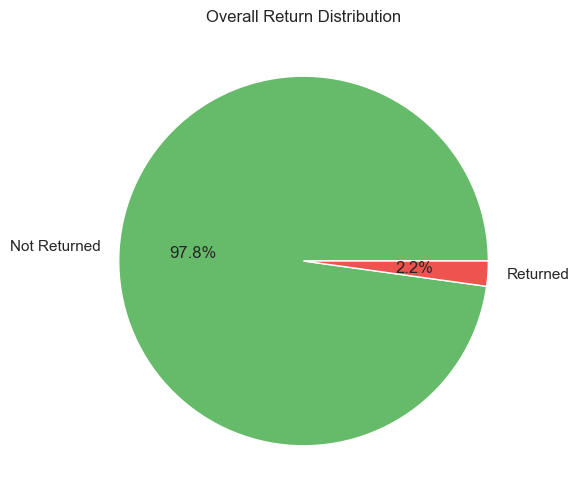

In [10]:
return_counts = df['return_flag'].value_counts()
labels = ['Not Returned', 'Returned']

plt.figure(figsize=(6, 6))
plt.pie(return_counts, labels=labels, autopct='%1.1f%%', colors=['#66bb6a', '#ef5350'])
plt.title("Overall Return Distribution")
plt.show()

Return Rate by Country (Top 10 Countries)

C:\Users\HOME\AppData\Local\Temp\ipykernel_13388\868037807.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top, x='Country', y='return_flag', estimator='mean', palette='coolwarm')


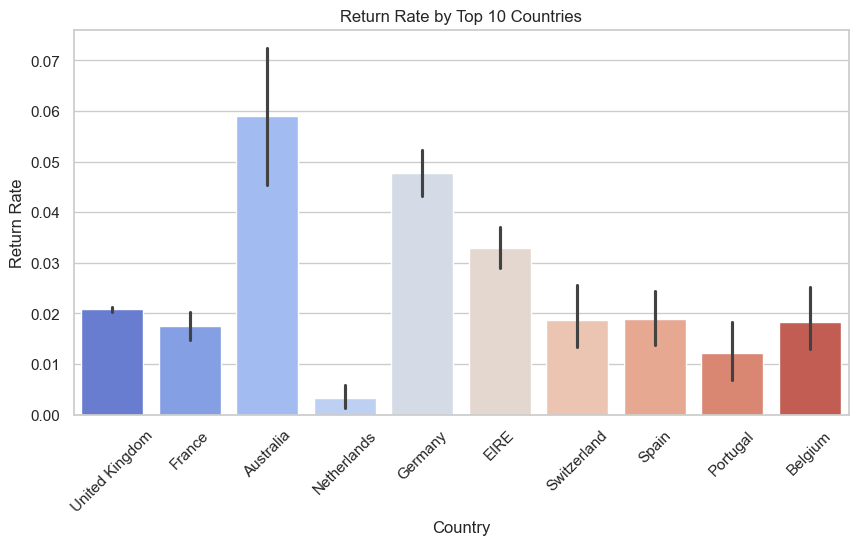

In [11]:
top_countries = df['Country'].value_counts().head(10).index
df_top = df[df['Country'].isin(top_countries)]

plt.figure(figsize=(10, 5))
sns.barplot(data=df_top, x='Country', y='return_flag', estimator='mean', palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Return Rate by Top 10 Countries")
plt.ylabel("Return Rate")
plt.show()

Monthly Return Trends

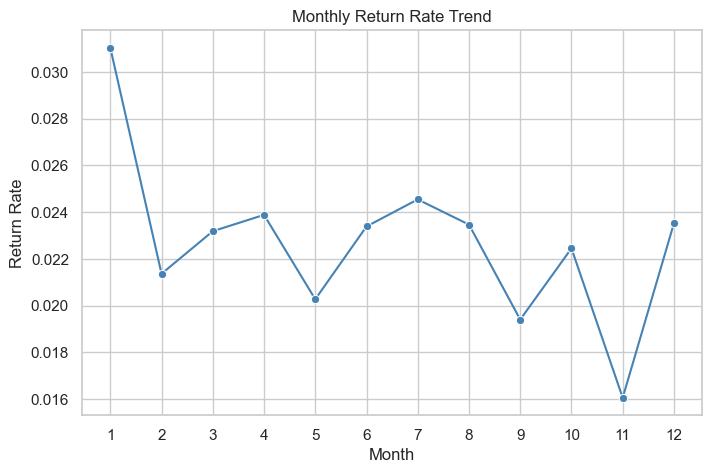

In [12]:
monthly_return = df.groupby('Month')['return_flag'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(data=monthly_return, x='Month', y='return_flag', marker='o', color='steelblue')
plt.title("Monthly Return Rate Trend")
plt.ylabel("Return Rate")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

Logistic Regression Prediction  

In [13]:
#import Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [25]:
#Load and Prepare Data
# Load cleaned CSV
df = pd.read_csv("cleaned_orders.csv")

# Optional: Drop nulls in critical columns
df.dropna(subset=['StockCode', 'Country'], inplace=True)

# Create features and target
features = df[['Quantity', 'UnitPrice', 'order_value', 'Month', 'Hour', 'Country']]
target = df['return_flag']

In [26]:
#Encode Categorical Variables
# One-hot encode Country and StockCode
features_encoded = pd.get_dummies(features, columns=['Country'], drop_first=True)
print(f"Final shape of encoded data: {features_encoded.shape}")

Final shape of encoded data: (406789, 41)


In [29]:
#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, stratify=target, random_state=42)
#Fit Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [30]:
# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79577
           1       1.00      1.00      1.00      1781

    accuracy                           1.00     81358
   macro avg       1.00      1.00      1.00     81358
weighted avg       1.00      1.00      1.00     81358

ROC AUC Score: 1.0


In [34]:
#Add risk_score to Full Dataset
df['risk_score'] = model.predict_proba(features_encoded)[:, 1]

# Preview top high-risk returns
high_risk = df[df['risk_score'] > 0.7]
print(high_risk[['InvoiceNo', 'Description', 'risk_score']].head())

    InvoiceNo                       Description  risk_score
141   C536379                          Discount         1.0
154   C536383   SET OF 3 COLOURED  FLYING DUCKS         1.0
235   C536391    PLASTERS IN TIN CIRCUS PARADE          1.0
236   C536391  PACK OF 12 PINK PAISLEY TISSUES          1.0
237   C536391  PACK OF 12 BLUE PAISLEY TISSUES          1.0


 Exporting High-Risk Products to CSV

In [32]:
high_risk.to_csv("high-risk products.csv", index=False)